### CaseHOLD error analysis

In this notebook, we compare the results of the LLM generated labels with the ground truth labels. 

In [1]:
import pandas as pd
from datasets import load_dataset
from langchain_aws import ChatBedrockConverse
import numpy as np
from sklearn.metrics import f1_score
import re

In [2]:
test = pd.read_csv('casehold_test.csv')

In [3]:
def extract_answers(text):
    if pd.isnull(text):
        return -1
    # Look for text surrounded by single backticks
    pattern = r"(?::| |\`)([A-E])(?:\`|$)"
    match = re.search(pattern, text)
    letter = match.group(1) if match else ''

    if letter:
        # Return the content if found, None otherwise
        return ord(letter) - ord('A')
    else: 
        return -1

In [4]:
test['answer_nova_micro'] = test['response_nova_micro'].apply(lambda x: extract_answers(x))
test['answer_nova_lite'] = test['response_nova_lite'].apply(lambda x: extract_answers(x))
test['answer_nova_pro'] = test['response_nova_pro'].apply(lambda x: extract_answers(x))

test['answer_llama_1b'] = test['response_llama_1b'].apply(lambda x: extract_answers(x))
test['answer_llama_3b'] = test['response_llama_3b'].apply(lambda x: extract_answers(x))
test['answer_llama_11b'] = test['response_llama_11b'].apply(lambda x: extract_answers(x))
test['answer_llama_90b'] = test['response_llama_90b'].apply(lambda x: extract_answers(x))



### Missing analysis

How often did the LLM return a response we can automatically parse?

In [5]:
def completeness_metric(missing, total):
    return 100.0 * (total - missing) / total

In [6]:
(completeness_metric(test.query('answer_nova_micro == -1').shape[0], test.shape[0]), 
completeness_metric(test.query('answer_nova_lite == -1').shape[0], test.shape[0]),
completeness_metric(test.query('answer_nova_pro == -1').shape[0], test.shape[0]),
completeness_metric(test.query('answer_llama_1b == -1').shape[0], test.shape[0]),
completeness_metric(test.query('answer_llama_3b == -1').shape[0], test.shape[0]),
completeness_metric(test.query('answer_llama_11b == -1').shape[0], test.shape[0]),
completeness_metric(test.query('answer_llama_90b == -1').shape[0], test.shape[0]))

(99.96236356793376,
 99.39781708694017,
 99.96236356793376,
 91.1742566804667,
 99.1531802785096,
 98.81445238991344,
 99.98118178396687)

#### An example of a response we could not parse

In [7]:
test.query('answer_llama_3b == -1')['response_llama_3b'].iloc[3]

"To determine the best replacement for the `<HOLDING>` tag, let's analyze the context and the options provided.\n\nThe `<HOLDING>` tag is used to indicate the actual holding or decision of the court in a case. In this context, it seems to be referring to the requirement that the EMTALA's transfer provisions must be triggered.\n\nOption C: `C: holding that the transfer restrictions of 42 usc 1395ddc apply only when an individual comes to the emergency room and after an appropriate medical screening examination the hospital determines that the individual has an emergency medical condition` seems to be the most relevant and accurate replacement for the `<HOLDING>` tag. This option directly addresses the requirement for triggering the EMTALA's transfer provisions, which is the central issue in the provided text.\n\nThe other options do not directly relate to the trigger requirement for the EMTALA's transfer provisions and are therefore not suitable replacements for the `<HOLDING>` tag."

#### And answers we could parse

In [8]:
index = 235
model_id = 'llama_1b'
print('LLM Answer: {}'.format(test.loc[index]['answer_{}'.format(model_id)]))
print('LLM Raw Response: {}'.format(test.loc[index]['response_{}'.format(model_id)]))


LLM Answer: 2
LLM Raw Response: ANSWER:`C`

The correct answer is C: recognizing that issue exhaustion requirement and requirement exhaustion are different.

The issue exhaustion requirement is a jurisdictional requirement that applies to federal habeas petitions, whereas the requirement for exhaustion of remedies is a procedural requirement that applies to state habeas petitions. The holding in Wilson v. Jones (2005) is actually a correct statement of law, as it recognizes that the issue exhaustion requirement applies to excessive force claims, not excessive force claims that are not subject to exhaustion.

The correct reasoning is:

* The issue exhaustion requirement is a jurisdictional requirement that applies to federal habeas petitions.
* The requirement for exhaustion of remedies is a procedural requirement that applies to state habeas petitions.
* The Wilson v. Jones (2005) holding is a correct statement of law, as it recognizes that the issue exhaustion requirement applies to e

In [9]:
model_id = 'llama_90b'
print('LLM Answer: {}'.format(test.loc[index]['answer_{}'.format(model_id)]))
print('LLM Raw Response: {}'.format(test.loc[index]['response_{}'.format(model_id)]))


LLM Answer: 4
LLM Raw Response: To determine the best replacement for the <HOLDING> tag, we need to analyze the context of the passage. The passage discusses the requirement for a habeas petitioner to exhaust state remedies before seeking redress in federal courts. It specifically mentions that Gordon failed to demonstrate exhaustion of state remedies for his claims and did not attempt to excuse his failure to exhaust.

Given this context, we can infer that the holding in Wilson v. Jones (430 F.3d 1113, 1118 (10th Cir.2005)) is likely related to the exhaustion requirement. The passage does not provide any information about excessive force claims, so options A and B are unlikely to be correct.

Option C, recognizing that issue exhaustion requirement and requirement exhaustion of remedies are different, is a plausible choice, but it does not directly relate to the context of the passage, which focuses on the requirement to exhaust state remedies.

Option D, holding that exhaustion of iss

### Impute any missing values with a random guess

In [10]:
#Fill in random guesses elsewhere
test.loc[test['answer_nova_micro'] == -1, 'answer_nova_micro'] = np.random.choice(5, size = test.query('answer_nova_micro == -1').shape[0])
test.loc[test['answer_nova_lite'] == -1, 'answer_nova_lite'] = np.random.choice(5, size = test.query('answer_nova_lite == -1').shape[0])
test.loc[test['answer_nova_pro'] == -1, 'answer_nova_pro'] = np.random.choice(5, size = test.query('answer_nova_pro == -1').shape[0])

test.loc[test['answer_llama_1b'] == -1, 'answer_llama_1b'] = np.random.choice(5, size = test.query('answer_llama_1b == -1').shape[0])
test.loc[test['answer_llama_3b'] == -1, 'answer_llama_3b'] = np.random.choice(5, size = test.query('answer_llama_3b == -1').shape[0])
test.loc[test['answer_llama_11b'] == -1, 'answer_llama_11b'] = np.random.choice(5, size = test.query('answer_llama_11b == -1').shape[0])
test.loc[test['answer_llama_90b'] == -1, 'answer_llama_90b'] = np.random.choice(5, size = test.query('answer_llama_90b == -1').shape[0])

### Macro F1 Score
This is likely equivalent to accuracy in this cases (since classes are basically balanced), but using it to ensure comparability with published results.

In [11]:
(f1_score(test['label'], test['answer_nova_micro'], average='macro'), 
f1_score(test['label'], test['answer_nova_lite'], average='macro'),
f1_score(test['label'], test['answer_nova_pro'], average='macro'),
f1_score(test['label'], test['answer_llama_1b'], average='macro'),
f1_score(test['label'], test['answer_llama_3b'], average='macro'),
f1_score(test['label'], test['answer_llama_11b'], average='macro'),
f1_score(test['label'], test['answer_llama_90b'], average='macro'))


(0.5990264119203005,
 0.6756669466049366,
 0.7061547014403107,
 0.27332202993271737,
 0.5255622770677866,
 0.6111116044699609,
 0.7138425651864675)

In [12]:
from plotnine import *

In [13]:
results = pd.DataFrame([('CustomLegal-BERT', 0.695), ('NovaMicro', 0.599), ('NovaLite', 0.675), ('NovaPro', 0.706), ('Llama3.2-1B', 0.275), ('Llama3.2-3B', 0.527), ('Llama3.2-11B', 0.611), ('Llama3.2-90B', 0.713)], columns = ['model', 'f1_score'])

In [14]:
results['model'] = pd.Categorical(results['model'], ordered=True, categories = ['CustomLegal-BERT','Llama3.2-1B', 'Llama3.2-3B', 'Llama3.2-11B', 'Llama3.2-90B', 'NovaMicro', 'NovaLite', 'NovaPro' ])

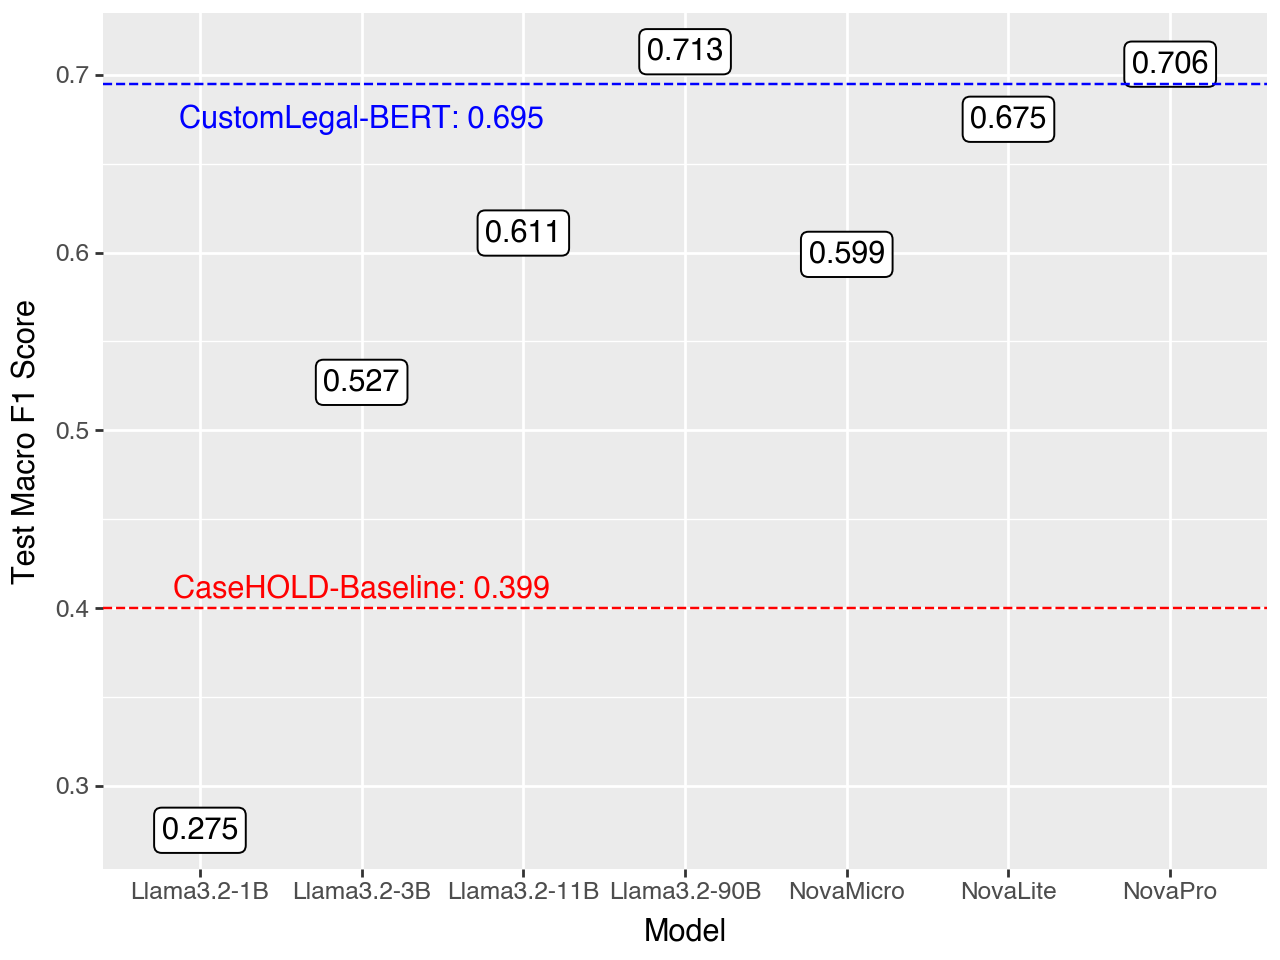

In [15]:
ggplot(mapping = aes(x = 'model', y = 'f1_score'), data = results) + geom_point(data = results[results['model'] != "CustomLegal-BERT"]) +\
geom_label(aes(label = 'f1_score'), data = results[results['model'] != "CustomLegal-BERT"]) +\
geom_hline(aes(yintercept = 0.695), linetype = 'dashed', color = 'blue') + annotate("text", x = 'Llama3.2-3B', y = 0.675, label = "CustomLegal-BERT: 0.695", color = 'blue') +\
geom_hline(aes(yintercept = 0.4), linetype = 'dashed', color = 'red') + annotate("text", x = 'Llama3.2-3B', y = 0.41, label = "CaseHOLD-Baseline: 0.399", color = 'red') + xlab("Model") + ylab("Test Macro F1 Score")

In [16]:
test['correct_nova_micro'] = test['label'] ==  test['answer_nova_micro']
test['correct_nova_lite'] = test['label'] ==  test['answer_nova_lite']
test['correct_nova_pro'] = test['label'] ==  test['answer_nova_pro']
test['correct_llama_1b'] = test['label'] ==  test['answer_llama_1b']
test['correct_llama_3b'] = test['label'] ==  test['answer_llama_3b']
test['correct_llama_11b'] = test['label'] ==  test['answer_llama_11b']
test['correct_llama_90b'] = test['label'] ==  test['answer_llama_90b']

### How much do the LLM answers differ?

In [17]:
from sklearn.metrics import pairwise_distances

In [18]:
vars = ['answer_nova_micro', 'answer_nova_lite', 'answer_nova_pro', 'answer_llama_1b', 'answer_llama_3b', 'answer_llama_11b', 'answer_llama_90b']

matchrate = pd.DataFrame(1 - pairwise_distances(test[vars].values.T, metric = 'hamming'), columns = vars, index = vars)
matchrate = matchrate.reset_index()

In [19]:
m_matchrate = pd.melt(matchrate, id_vars = 'index')
m_matchrate = m_matchrate.rename(columns = {'index': 'first', 'variable': 'second'})

m_matchrate['first'] = pd.Categorical(m_matchrate['first'], ordered=True, categories = vars)
m_matchrate['second'] = pd.Categorical(m_matchrate['second'], ordered=True, categories = vars)

In [20]:
m_matchrate['MatchRate'] = np.round(100 * m_matchrate['value'], 1)

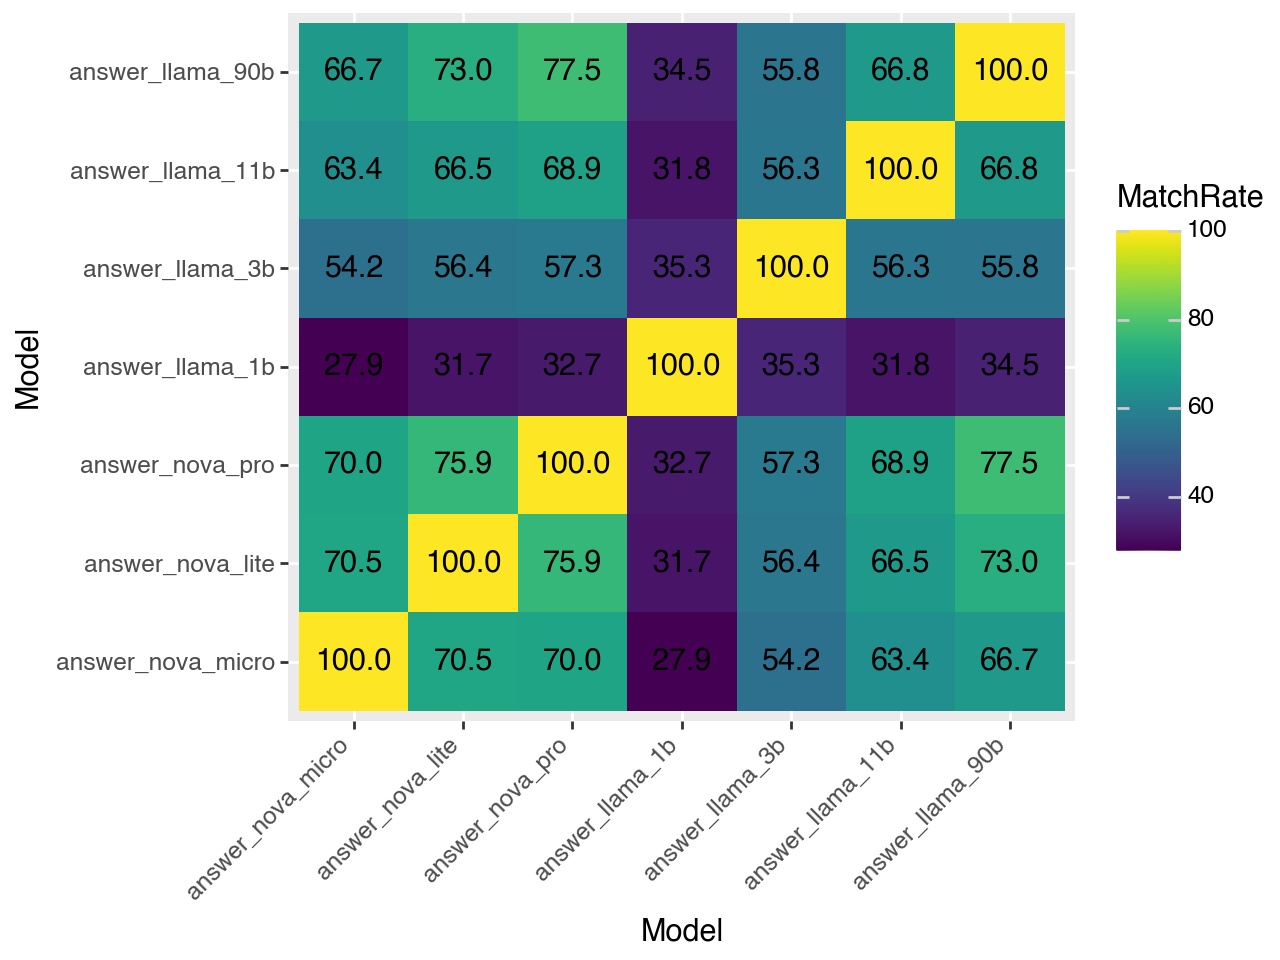

In [21]:
ggplot(mapping = aes(x = 'second', y = 'first', fill = 'MatchRate'), data = m_matchrate) + geom_tile() + geom_text(aes(label = 'MatchRate')) + theme(axis_text_x = element_text(angle = 45 , hjust = 1)) + xlab("Model") + ylab("Model")

### How often do LLMs diverge on a given problem?

In [22]:
vars = ['answer_nova_micro', 'answer_nova_lite', 'answer_nova_pro', 'answer_llama_3b', 'answer_llama_11b', 'answer_llama_90b']

num_unique_responses = test[vars].T.nunique().to_frame(name = 'num_unique_responses')

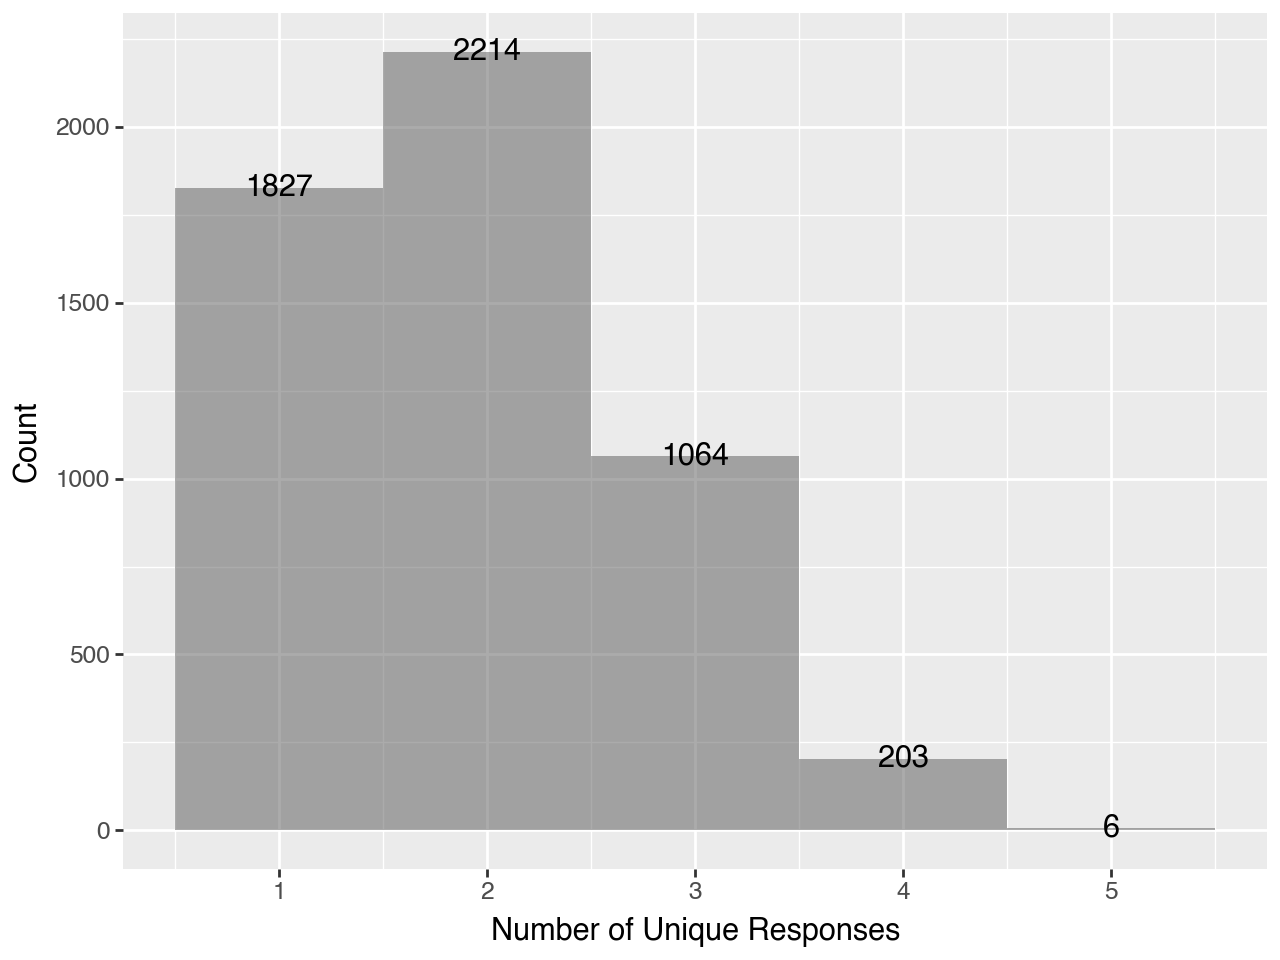

In [23]:
ggplot(mapping = aes(x = 'num_unique_responses'), data = num_unique_responses) + geom_histogram(binwidth = 1, alpha = 0.5) + xlab("Number of Unique Responses") + ylab("Count") +\
stat_count(mapping = aes( label = after_stat('count'))
           , width = 1
           , geom = 'text')

In [24]:
test = pd.concat([test, num_unique_responses], axis = 1)

In [25]:
full = []

for v in ['correct_nova_micro', 'correct_nova_lite', 'correct_nova_pro', 'correct_llama_3b', 'correct_llama_11b', 'correct_llama_90b']:
    a = test.groupby('num_unique_responses')[v].agg(['mean', 'count']).reset_index()
    a['model'] = v
    full.append(a)

full = pd.concat(full)
full['model'] = pd.Categorical(full['model'], ordered = True, categories = ['correct_llama_3b', 'correct_llama_11b', 'correct_llama_90b', 'correct_nova_micro', 'correct_nova_lite', 'correct_nova_pro'])

In [26]:
full

,num_unique_responses,mean,count,model
0,1,0.905309,1827,correct_nova_micro
1,2,0.546070,2214,correct_nova_micro
2,3,0.281015,1064,correct_nova_micro
3,4,0.206897,203,correct_nova_micro
4,5,0.000000,6,correct_nova_micro
0,1,0.905309,1827,correct_nova_lite
1,2,0.641373,2214,correct_nova_lite
2,3,0.430451,1064,correct_nova_lite
3,4,0.290640,203,correct_nova_lite
4,5,0.500000,6,correct_nova_lite


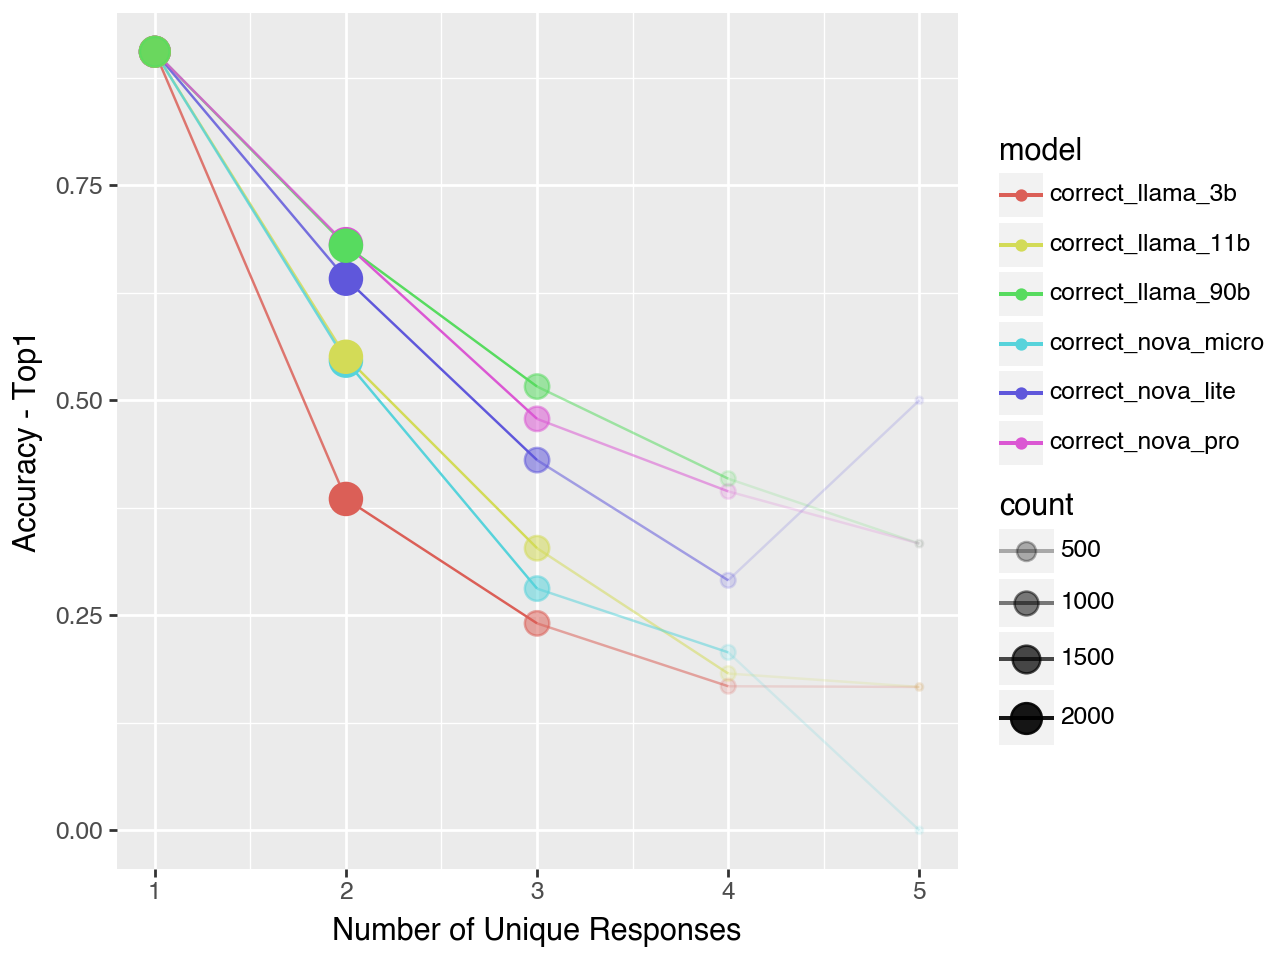

In [27]:
ggplot(mapping = aes(x = 'num_unique_responses', y = 'mean', color = 'model', alpha = 'count'), data = full) + geom_line() + geom_point(aes(size = 'count')) + xlab("Number of Unique Responses") + ylab("Accuracy - Top1") + scale_color_discrete()

In [28]:
test.groupby('num_unique_responses')['correct_nova_pro'].agg(['mean', 'count'])

,mean,count
num_unique_responses,,
1,0.905309,1827
2,0.681572,2214
3,0.478383,1064
4,0.394089,203
5,0.333333,6


### Anecdotal examples

In [29]:
test.groupby(['correct_llama_90b', 'correct_nova_pro'])['example_id'].count()

correct_llama_90b  correct_nova_pro
False              False               1065
                   True                 456
True               False                495
                   True                3298
Name: example_id, dtype: int64

In [30]:
test.groupby(['correct_nova_micro', 'correct_nova_pro'])['example_id'].count()

correct_nova_micro  correct_nova_pro
False               False               1234
                    True                 876
True                False                326
                    True                2878
Name: example_id, dtype: int64

In [31]:
for c in test.columns: 
    print('***{}***'.format(c))
    print(test.iloc[2021][c])

***Unnamed: 0***
2021
***example_id***
49842
***citing_prompt***
nominal owner. This claim may be cognizable under New York rulings that have recognized ownership in persons other than owners of record. For example, in Ryen v. Terry (In re Terry), 56 B.R. 713 (Bankr.W.D.N.Y.1986), a bankruptcy trustee sued to recover a disability payment of $19,000 that the debtor had deposited in her mother's bank account. Although the mother had sole legal title to the funds, the bankruptcy court granted the trustee's motion for turnover, holding that a bailment had been created by the debtor's deposit of funds into her mother's account, and that “[ujnder the bailment, the debtor did not transfer her equitable nor beneficial interests in those funds to her mother.” Id. at 715. See also Herzfeld & Stern v. Freidus, 69 Misc.2d 578, 330 N.Y.S.2d 479 (1st Dep't 1971) (<HOLDING>); Bottiglieri v. Berman, 55 Misc.2d 263, 284
***holding_0***
holding that where both vessels had the same owner it was not an ab

In [32]:
for c in test.columns: 
    print('***{}***'.format(c))
    print(test.iloc[21][c])

***Unnamed: 0***
21
***example_id***
47842
***citing_prompt***
argument. Pursuant to 29 U.S.C. § 626(e)(2), the statute of limitations may be tolled up to one year for the period during which the EEOC attempts compliance with the ADEA’s requirements through conciliation. Therefore, together with the extension for willful violations, conciliation may extend the statute of limitations for a total of four years. O’Rourke v. Continental Casualty Co., 983 F.2d 94, 95 (7th Cir.1993). The conciliation period begins, thereby tolling the filing period, when the EEOC issues a letter of violation. E.E.O.C. v. Barrett, Haentjens & Co., 705 F.Supp. 1065, 1069 (M.D.Pa.1988) (citing the Congressional and Administrative News); U.S. Equal Employment Opportunity Commission v. Francis W. Parker School, 91 C 4674, 1993 WL 106523, at *4 (N.D.Ill. Mar. 24, 1993) (<HOLDING>); but see Equal Employment Opportunity
***holding_0***
holding that the 120day filing period is subject to equitable tolling and address